<a href="https://colab.research.google.com/github/bth0114/AIFFEL_DLThon_DKTC_online13/blob/main/notebooks/taehoon/EXP_augument_with_KcElECTRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install konlpy
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 24.1 MB/s eta 0:00:00


## 모듈 불러오기 및 파일 경로 지정

In [2]:
import os
import re
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import wandb
from wandb.integration.keras.callbacks import WandbMetricsLogger
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


True

In [3]:
#  GitHub에서 CSV 파일 다운로드
!mkdir -p data/raw_csv
!wget https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/raw_csv/merged_train.csv -O data/raw_csv/merged_train.csv

#  현재 디렉토리 기준 경로 설정
current_dir = os.getcwd()
csv_dir = os.path.join(current_dir, 'data', 'raw_csv')
train_csv_path = os.path.join(csv_dir, 'merged_train.csv')

#  데이터 로드 테스트
df = pd.read_csv(train_csv_path)
print("샘플 5개:")
print(df.head())

--2025-05-04 01:38:49--  https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/raw_csv/merged_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2547026 (2.4M) [application/octet-stream]
Saving to: ‘data/raw_csv/merged_train.csv’

data/raw_csv/merged 100%[===================>]   2.43M  --.-KB/s    in 0.01s   

2025-05-04 01:38:50 (228 MB/s) - ‘data/raw_csv/merged_train.csv’ saved [2547026/2547026]

샘플 5개:
    idx      class                                       conversation
0  1516      갈취 대화  어이 가방 좋은데!?\n네!? 왜 그러시죠\n아니 우리가 밥을 굶어서 편의점 라면이...
1  5078      일반 대화  요즘 읽고 있는 책 있어?\n그거 좋은 생각이야.\n좋은 시간 보냈네.\n조언 고마...
2   350      협박 대화  간도 커 어딜 튀려고 !\n아니 미주엄마 내가 딱 일주일만 더 쓰고 주려고 했는데 ...
3  3247  기타 괴롭힘 대화  야 너 뭐하냐\n공부해\n뭔공부\n토익공부\n그

## 데이터 전처리
- 구두점 제거
- 명사, 동사, 형용사, 부사, 숫자를 기준으로 토큰화
- 최대 길이를 기준으로 패딩

In [4]:
INPUT_MAX_LENGTH = 350  # 입력 시퀀스 최대 길이
NUM_WORDS = 7000 # 토큰화에 사용할 단어 갯수
EMBEDDING_DIM = 64  # 임베딩 차원

In [33]:
df = pd.read_csv(train_csv_path)
ordered_columns = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반 대화'] # kaggle에 명시된 순서로 재배치

conversations = df['conversation'].to_list() # input
labels = pd.get_dummies(df['class'])
labels = labels[ordered_columns].to_numpy() # target

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#학습 데이터 경로
train_paths = {
    "conversations_aihub": "https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/raw_csv/conversations_aihub.csv",
    "merged_train": "https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/raw_csv/merged_train.csv",
    "merged_train_train": "https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/raw_csv/merged_train_train.csv",
    "merged_train_val": "https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/raw_csv/merged_train_val.csv",
    "aug_synonym_train_only" : "https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/aug_csv/aug_synonym_train_only.csv",
    "aug_KoEDA_train_only":"https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/aug_csv/aug_KoEDA_train_only.csv",
    "aug_plus": "https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/aug_csv/aug_plus_train.csv",
    "aug_synonym": "https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/aug_csv/aug_synonym_train_only.csv",
    "eda_only": "https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/aug_csv/eda_only.csv",
    "final_allclass": "https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/aug_csv/final_train_allclass_eda.csv"
}

# 제출용 test 데이터 경로
test_url = "https://raw.githubusercontent.com/bth0114/AIFFEL_DLThon_DKTC_online13/main/data/raw_csv/test.csv"

In [35]:
# 1. 데이터 불러오기
df_merged_train_train = pd.read_csv(train_paths["merged_train_train"])
df_merged_train_val = pd.read_csv(train_paths["merged_train_val"])
df_conversations_aihub = pd.read_csv(train_paths["conversations_aihub"])
df_syn = pd.read_csv(train_paths["aug_synonym"])
df_eda = pd.read_csv(train_paths["eda_only"])
df_syn_only = pd.read_csv(train_paths["aug_synonym_train_only"])
df_eda_only = pd.read_csv(train_paths["aug_KoEDA_train_only"])

In [36]:
# 2. 라벨 인코딩

# 원하는 정수 순서 지정
custom_label_order = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화': 4
}

# 원-핫이 아니라 문자열 클래스인 경우 바로 정수로 변환
y_train_int = df_merged_train_train['class'].map(custom_label_order).values
y_val_int = df_merged_train_val['class'].map(custom_label_order).values

In [37]:
#label_names = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반 대화']
#le = LabelEncoder()
#le.fit(label_names)
#y_train_int = np.argmax(y_train, axis=1)  # 기존 y_train이 one-hot일 경우

In [38]:
# 훈련셋,검증셋 분리

# 1. 입력 텍스트
X_train_raw = df_merged_train_train["conversation"]
X_val_raw = df_merged_train_val["conversation"]

# 2. 클래스 → 정수 인코딩
y_train = df_merged_train_train["class"].map(custom_label_order).values
y_val = df_merged_train_val["class"].map(custom_label_order).values

In [39]:
# 증강 데이터 라벨 인코딩
X_syn_only = df_syn_only['conversation'].tolist()
y_syn_only = df_syn_only['class'].map(custom_label_order).values

X_eda_only = df_eda_only['conversation'].tolist()
y_eda_only = df_eda_only['class'].map(custom_label_order).values

# 조합 생성
X1 = X_train_raw.tolist()
y1 = y_train_int

X2 = X1 + X_syn_only
y2 = np.concatenate([y_train, y_syn_only])

X3 = X1 + X_eda_only
y3 = np.concatenate([y_train, y_eda_only])

X4 = X1 + X_syn_only + X_eda_only
y4 = np.concatenate([y_train, y_syn_only, y_eda_only])

# 예시 확인
print(f"샘플 수\nX1: {len(X1)}, X2: {len(X2)}, X3: {len(X3)}, X4: {len(X4)}")

샘플 수
X1: 3709, X2: 10032, X3: 9861, X4: 16184


In [40]:
def preprocessing(texts, tokenizer, padded_max_len):
    encodings = tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=padded_max_len,
        return_tensors='tf'
    )
    return {
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask']
    }


from tensorflow.keras.utils import to_categorical

X1_enc = preprocessing(X1, tokenizer, padded_max_len=128)
X2_enc = preprocessing(X2, tokenizer, padded_max_len=128)
X3_enc = preprocessing(X3, tokenizer, padded_max_len=128)
X4_enc = preprocessing(X4, tokenizer, padded_max_len=128)




y1_cat = to_categorical(y1, num_classes=5)
y2_cat = to_categorical(y2, num_classes=5)
y3_cat = to_categorical(y3, num_classes=5)
y4_cat = to_categorical(y4, num_classes=5)

#  검증셋 전처리 추가
X_val_enc = preprocessing(X_val_raw.tolist(), tokenizer, padded_max_len=128)

#  검증 라벨도 one-hot 인코딩
y_val_cat = to_categorical(y_val, num_classes=5)

## 모델 훈련
- KcELECTRA 모델 사용
- 각 데이터셋별로 모델을 학습
- F1score를 기준으로 조기종료 수행
- 데이터 셋이 적어 여러번 반복 훈련하여 평균을 내면 더욱 정확한 베이스 모델을 구축할 수 있지만 시간과 한정된 자원 상 한 번의 학습만 진행
- 실험결과는 W&B에 기록

In [41]:
!pip install datasets transformers scikit-learn --quiet

import pandas as pd
import numpy as np
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    ElectraForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from sklearn.metrics import accuracy_score,classification_report, f1_score

# 모델 설정 (성능 좋은 버전)
MODEL_NAME = "beomi/KcELECTRA-base-v2022"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ElectraForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=5).to(device)

# 학습 데이터 전처리
def preprocess_train(df):
    df.columns = df.columns.str.strip().str.lower()
    df["label"] = df["class"].map(custom_label_order)
    df = df.rename(columns={"conversation": "text"})
    return Dataset.from_pandas(df)

#  테스트 데이터 전처리 (라벨 없음)
def preprocess_test(df):
    df.columns = df.columns.str.strip().str.lower()
    df = df.rename(columns={"conversation": "text"})
    return Dataset.from_pandas(df)

# 토크나이징 함수
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

# 평가 함수 (정확도 + F1)
def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split

dataset_names = ["원본", "원본+Synonym", "원본+EDA", "원본+Syn+EDA"]
X_list = [X1, X2, X3, X4]
y_list = [y1, y2, y3, y4]

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

for i, (X, y, name) in enumerate(zip(X_list, y_list, dataset_names), 1):
    print(f"\n▶ 모델 {i}: {name}")

    # ⛳ 여기가 핵심! X, y를 train/val로 분리
    X_train_split, _, y_train_split, _ = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # 공통 검증셋은 y_val, X_val_raw 그대로 사용
    train_df = pd.DataFrame({"text": X_train_split, "label": y_train_split})
    val_df = pd.DataFrame({"text": X_val_raw.tolist(), "label": y_val})  # 여기서 val은 고정

    # Hugging Face Dataset + Tokenize
    train_dataset = Dataset.from_pandas(train_df).map(tokenize_function, batched=True)
    val_dataset = Dataset.from_pandas(val_df).map(tokenize_function, batched=True)

    model = ElectraForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=5).to(device)

    training_args = TrainingArguments(
        output_dir=f"./results/model_{i}",
        num_train_epochs=2,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        learning_rate=3e-5,
        weight_decay=0.01,
        logging_dir=f"./results/logs_{i}",
        logging_steps=500
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    trainer.train()
    trainer.save_model(f"./results/model_{i}")



▶ 모델 1: 원본


Map:   0%|          | 0/2967 [00:00<?, ? examples/s]

Map:   0%|          | 0/928 [00:00<?, ? examples/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-49-3cd94dc63c0f>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss



▶ 모델 2: 원본+Synonym


Map:   0%|          | 0/8025 [00:00<?, ? examples/s]

Map:   0%|          | 0/928 [00:00<?, ? examples/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-49-3cd94dc63c0f>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.458700
1000,0.091600



▶ 모델 3: 원본+EDA


Map:   0%|          | 0/7888 [00:00<?, ? examples/s]

Map:   0%|          | 0/928 [00:00<?, ? examples/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-49-3cd94dc63c0f>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.513300



▶ 모델 4: 원본+Syn+EDA


Map:   0%|          | 0/12947 [00:00<?, ? examples/s]

Map:   0%|          | 0/928 [00:00<?, ? examples/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-49-3cd94dc63c0f>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.472500
1000,0.153700
1500,0.049900


In [50]:
from sklearn.metrics import classification_report

# 1. 검증셋 준비
val_df = pd.DataFrame({"text": X_val_raw.tolist(), "label": y_val})
val_dataset = Dataset.from_pandas(val_df).map(tokenize_function, batched=True)

# 2. 라벨 이름 설정
label_names = list(custom_label_order.keys())

# 3. 모델별 평가
print("\n✅ 모델별 검증 성능 비교")
for i, name in enumerate(dataset_names, 1):
    print(f"\n▶ 모델 {i}: {name}")

    # 모델 불러오기
    model_path = f"./results/model_{i}"
    model = ElectraForSequenceClassification.from_pretrained(model_path).to(device)

    # 평가용 Trainer
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # 예측
    preds = trainer.predict(val_dataset)
    y_pred = np.argmax(preds.predictions, axis=1)

    # 평가 리포트 출력
    print(classification_report(y_val, y_pred, target_names=label_names))


Map:   0%|          | 0/928 [00:00<?, ? examples/s]


✅ 모델별 검증 성능 비교

▶ 모델 1: 원본


<ipython-input-50-0dc0463eb819>:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


              precision    recall  f1-score   support

       협박 대화       0.86      0.89      0.87       179
       갈취 대화       0.87      0.89      0.88       195
 직장 내 괴롭힘 대화       0.97      0.95      0.96       194
   기타 괴롭힘 대화       0.90      0.85      0.88       202
       일반 대화       0.98      0.99      0.99       158

    accuracy                           0.91       928
   macro avg       0.92      0.92      0.92       928
weighted avg       0.91      0.91      0.91       928


▶ 모델 2: 원본+Synonym


<ipython-input-50-0dc0463eb819>:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


              precision    recall  f1-score   support

       협박 대화       0.87      0.87      0.87       179
       갈취 대화       0.85      0.90      0.87       195
 직장 내 괴롭힘 대화       0.94      0.97      0.96       194
   기타 괴롭힘 대화       0.92      0.83      0.87       202
       일반 대화       0.97      0.99      0.98       158

    accuracy                           0.91       928
   macro avg       0.91      0.91      0.91       928
weighted avg       0.91      0.91      0.91       928


▶ 모델 3: 원본+EDA


<ipython-input-50-0dc0463eb819>:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


              precision    recall  f1-score   support

       협박 대화       0.89      0.87      0.88       179
       갈취 대화       0.84      0.90      0.87       195
 직장 내 괴롭힘 대화       0.94      0.97      0.95       194
   기타 괴롭힘 대화       0.89      0.83      0.86       202
       일반 대화       0.99      0.99      0.99       158

    accuracy                           0.91       928
   macro avg       0.91      0.91      0.91       928
weighted avg       0.91      0.91      0.91       928


▶ 모델 4: 원본+Syn+EDA


<ipython-input-50-0dc0463eb819>:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


              precision    recall  f1-score   support

       협박 대화       0.88      0.89      0.89       179
       갈취 대화       0.86      0.91      0.89       195
 직장 내 괴롭힘 대화       0.96      0.96      0.96       194
   기타 괴롭힘 대화       0.91      0.85      0.88       202
       일반 대화       0.99      0.99      0.99       158

    accuracy                           0.92       928
   macro avg       0.92      0.92      0.92       928
weighted avg       0.92      0.92      0.92       928



In [51]:
from wandb.integration.keras import WandbCallback
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#  공통 함수 정의
def log_model_to_wandb(model, run_name, notes, X_train, y_train, X_val, y_val, ordered_columns):
    import wandb
    from sklearn.metrics import classification_report


    run = wandb.init(
    entity="jiwoong-team",
    project="DLThon-DKTC",
    name=run_name,
    notes=notes,
    config=dict(
        architecture="KcELECTRA",
        input_length=128,
        epochs=10,
        batch_size=32
    ),
    reinit=True,
    settings=wandb.Settings(_disable_stats=True)
    )


    #  예측 결과 평가
    y_pred = model.predict(X_val)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_val, axis=1)

    #  classification report 테이블 생성
    report = classification_report(y_true_labels, y_pred_labels, target_names=ordered_columns, output_dict=True)
    columns = ["class", "precision", "recall", "f1-score", "support"]
    data = []
    for label, metrics in report.items():
        if isinstance(metrics, dict):
            row = [label] + [metrics.get(col, None) for col in columns[1:]]
            data.append(row)

    table = wandb.Table(columns=columns, data=data)

    wandb.log({
    "macro_f1": float(report["macro avg"]["f1-score"]),
    "accuracy": float(report["accuracy"]),
    "threat_f1": float(report["협박 대화"]["f1-score"]),
    "extortion_f1": float(report["갈취 대화"]["f1-score"]),
    "workplace_bullying_f1": float(report["직장 내 괴롭힘 대화"]["f1-score"]),
    "other_bullying_f1": float(report["기타 괴롭힘 대화"]["f1-score"]),
    "general_conversation_f1": float(report["일반 대화"]["f1-score"]),
    })


    run.finish()


In [55]:
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from sklearn.metrics import classification_report
import torch

def log_model_to_wandb(model, run_name, notes, X_train, y_train, X_val, y_val, ordered_columns):
    import wandb
    from transformers import AutoTokenizer
    from datasets import Dataset
    from tqdm import tqdm

    run = wandb.init(
        entity="jiwoong-team",
        project="DLThon-DKTC",
        name=run_name,
        notes=notes,
        config=dict(
            architecture="KcELECTRA",
            input_length=128,
            epochs=10,
            batch_size=32
        ),
        reinit=True,
        settings=wandb.Settings(_disable_stats=True)
    )

    # 토크나이즈
    val_df = pd.DataFrame({"text": X_val, "label": y_val})
    val_dataset = Dataset.from_pandas(val_df).map(tokenize_function, batched=True)
    val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])

    # 평가
    model.eval()
    y_preds = []
    y_trues = []

    dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=data_collator)

    for batch in tqdm(dataloader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = batch["attention_mask"].to(model.device)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        y_preds.extend(preds)

    y_true_labels = y_val
    y_pred_labels = y_preds

    # classification report
    report = classification_report(y_true_labels, y_pred_labels, target_names=ordered_columns, output_dict=True)
    columns = ["class", "precision", "recall", "f1-score", "support"]
    data = []
    for label, metrics in report.items():
        if isinstance(metrics, dict):
            row = [label] + [metrics.get(col, None) for col in columns[1:]]
            data.append(row)

    table = wandb.Table(columns=columns, data=data)

    wandb.log({
        "macro_f1": float(report["macro avg"]["f1-score"]),
        "accuracy": float(report["accuracy"]),
        "threat_f1": float(report["협박 대화"]["f1-score"]),
        "extortion_f1": float(report["갈취 대화"]["f1-score"]),
        "workplace_bullying_f1": float(report["직장 내 괴롭힘 대화"]["f1-score"]),
        "other_bullying_f1": float(report["기타 괴롭힘 대화"]["f1-score"]),
        "general_conversation_f1": float(report["일반 대화"]["f1-score"]),
        "classification_report": table
    })

    run.finish()


In [56]:
model1 = ElectraForSequenceClassification.from_pretrained("./results/model_1").to(device)
model2 = ElectraForSequenceClassification.from_pretrained("./results/model_2").to(device)
model3 = ElectraForSequenceClassification.from_pretrained("./results/model_3").to(device)
model4 = ElectraForSequenceClassification.from_pretrained("./results/model_4").to(device)

# 모델 1: 원본 데이터만
log_model_to_wandb(
    model1,
    run_name="KcELECTRA_original_only",
    notes="원본 데이터만 사용",
    X_train=X1, y_train=y1,
    X_val=X_val_raw, y_val=y_val,
    ordered_columns=ordered_columns
)

# 모델 2: 원본 + Synonym
log_model_to_wandb(
    model2,
    run_name="KcELECTRA_synonym",
    notes="원본 + Synonym 증강",
    X_train=X2, y_train=y2,
    X_val=X_val_raw, y_val=y_val,
    ordered_columns=ordered_columns
)
# 모델 3: 원본 + EDA
log_model_to_wandb(
    model3,
    run_name="KcELECTRA_eda",
    notes="원본 + EDA 증강",
    X_train=X3, y_train=y3,
    X_val=X_val_raw, y_val=y_val,
    ordered_columns=ordered_columns
)

# 모델 4: 원본 + Synonym + EDA
log_model_to_wandb(
    model4,
    run_name="KcELECTRA_synonym_eda",
    notes="원본 + Synonym + EDA 증강",
    X_train=X4_enc, y_train=y4_cat,
    X_val=X_val_raw, y_val=y_val,
    ordered_columns=ordered_columns
)


Map:   0%|          | 0/928 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.69it/s]


accuracy,▁
extortion_f1,▁
general_conversation_f1,▁
macro_f1,▁
other_bullying_f1,▁
threat_f1,▁
workplace_bullying_f1,▁
accuracy,0.91272
extortion_f1,0.87817
general_conversation_f1,0.98742
macro_f1,0.91525


Map:   0%|          | 0/928 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.69it/s]


accuracy,▁
extortion_f1,▁
general_conversation_f1,▁
macro_f1,▁
other_bullying_f1,▁
threat_f1,▁
workplace_bullying_f1,▁
accuracy,0.90841
extortion_f1,0.87282
general_conversation_f1,0.98113
macro_f1,0.9104


Map:   0%|          | 0/928 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.64it/s]


accuracy,▁
extortion_f1,▁
general_conversation_f1,▁
macro_f1,▁
other_bullying_f1,▁
threat_f1,▁
workplace_bullying_f1,▁
accuracy,0.90733
extortion_f1,0.86849
general_conversation_f1,0.99054
macro_f1,0.91003


Map:   0%|          | 0/928 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.59it/s]


accuracy,▁
extortion_f1,▁
general_conversation_f1,▁
macro_f1,▁
other_bullying_f1,▁
threat_f1,▁
workplace_bullying_f1,▁
accuracy,0.91918
extortion_f1,0.88557
general_conversation_f1,0.99367
macro_f1,0.92179


## 결과 분석

Map:   0%|          | 0/928 [00:00<?, ? examples/s]


 모델별 confusion matrix 및 classification report

 모델 1: 원본


<ipython-input-57-48dff5dd9374>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


Confusion Matrix:
[[160  11   3   5   0]
 [ 11 173   1   8   2]
 [  1   1 185   6   1]
 [ 15  13   2 172   0]
 [  0   1   0   0 157]]


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54801 (\N{HANGUL SYLLABLE HYEOB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48149 (\N{HANGUL SYLLABLE BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44040 (\N{HANGUL SYLLABLE GAL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 52712 (\N{HANGUL SYLLABLE CWI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/u

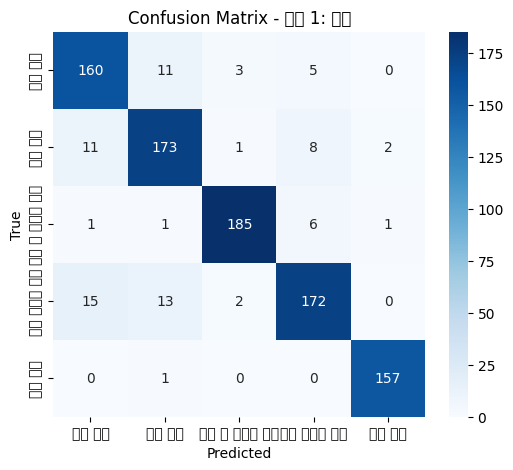

Classification Report:
              precision    recall  f1-score   support

       협박 대화       0.86      0.89      0.87       179
       갈취 대화       0.87      0.89      0.88       195
 직장 내 괴롭힘 대화       0.97      0.95      0.96       194
   기타 괴롭힘 대화       0.90      0.85      0.88       202
       일반 대화       0.98      0.99      0.99       158

    accuracy                           0.91       928
   macro avg       0.92      0.92      0.92       928
weighted avg       0.91      0.91      0.91       928


 모델 2: 원본+Synonym


<ipython-input-57-48dff5dd9374>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


Confusion Matrix:
[[155  16   4   4   0]
 [  8 175   2   8   2]
 [  1   0 189   3   1]
 [ 14  14   5 168   1]
 [  0   1   1   0 156]]


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54801 (\N{HANGUL SYLLABLE HYEOB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48149 (\N{HANGUL SYLLABLE BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44040 (\N{HANGUL SYLLABLE GAL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 52712 (\N{HANGUL SYLLABLE CWI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/u

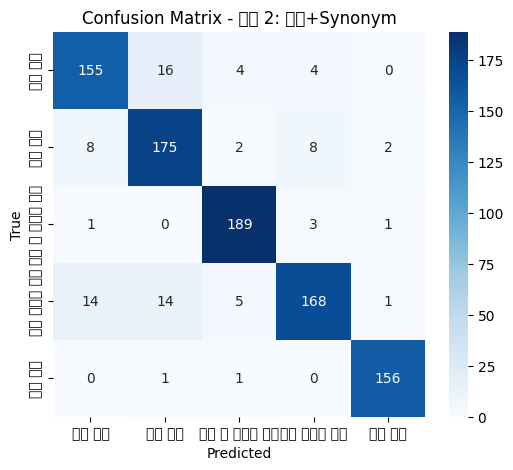

Classification Report:
              precision    recall  f1-score   support

       협박 대화       0.87      0.87      0.87       179
       갈취 대화       0.85      0.90      0.87       195
 직장 내 괴롭힘 대화       0.94      0.97      0.96       194
   기타 괴롭힘 대화       0.92      0.83      0.87       202
       일반 대화       0.97      0.99      0.98       158

    accuracy                           0.91       928
   macro avg       0.91      0.91      0.91       928
weighted avg       0.91      0.91      0.91       928


 모델 3: 원본+EDA


<ipython-input-57-48dff5dd9374>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


Confusion Matrix:
[[155  13   4   7   0]
 [  8 175   2   9   1]
 [  1   0 188   4   1]
 [ 10  19   6 167   0]
 [  0   1   0   0 157]]


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54801 (\N{HANGUL SYLLABLE HYEOB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48149 (\N{HANGUL SYLLABLE BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44040 (\N{HANGUL SYLLABLE GAL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 52712 (\N{HANGUL SYLLABLE CWI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/u

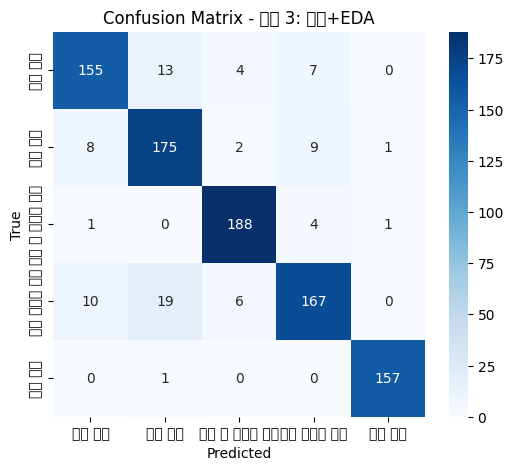

Classification Report:
              precision    recall  f1-score   support

       협박 대화       0.89      0.87      0.88       179
       갈취 대화       0.84      0.90      0.87       195
 직장 내 괴롭힘 대화       0.94      0.97      0.95       194
   기타 괴롭힘 대화       0.89      0.83      0.86       202
       일반 대화       0.99      0.99      0.99       158

    accuracy                           0.91       928
   macro avg       0.91      0.91      0.91       928
weighted avg       0.91      0.91      0.91       928


 모델 4: 원본+Syn+EDA


<ipython-input-57-48dff5dd9374>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


Confusion Matrix:
[[160  10   4   5   0]
 [  9 178   1   7   0]
 [  1   0 187   5   1]
 [ 11  18   2 171   0]
 [  0   1   0   0 157]]


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54801 (\N{HANGUL SYLLABLE HYEOB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48149 (\N{HANGUL SYLLABLE BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44040 (\N{HANGUL SYLLABLE GAL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 52712 (\N{HANGUL SYLLABLE CWI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/u

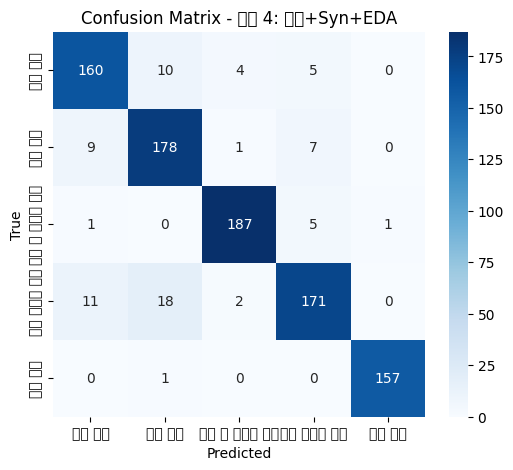

Classification Report:
              precision    recall  f1-score   support

       협박 대화       0.88      0.89      0.89       179
       갈취 대화       0.86      0.91      0.89       195
 직장 내 괴롭힘 대화       0.96      0.96      0.96       194
   기타 괴롭힘 대화       0.91      0.85      0.88       202
       일반 대화       0.99      0.99      0.99       158

    accuracy                           0.92       928
   macro avg       0.92      0.92      0.92       928
weighted avg       0.92      0.92      0.92       928



In [57]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 검증셋 준비
val_df = pd.DataFrame({"text": X_val_raw.tolist(), "label": y_val})
val_dataset = Dataset.from_pandas(val_df).map(tokenize_function, batched=True)

print("\n 모델별 confusion matrix 및 classification report")
for i, name in enumerate(dataset_names, 1):
    print(f"\n 모델 {i}: {name}")

    # 모델 불러오기
    model_path = f"./results/model_{i}"
    model = ElectraForSequenceClassification.from_pretrained(model_path).to(device)

    # 평가용 Trainer
    trainer = Trainer(model=model, tokenizer=tokenizer)

    # 예측 수행
    preds = trainer.predict(val_dataset)
    y_pred = np.argmax(preds.predictions, axis=1)
    y_true = y_val

    # confusion matrix 출력
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # 시각화
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ordered_columns, yticklabels=ordered_columns)
    plt.title(f"Confusion Matrix - 모델 {i}: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=ordered_columns))


Map:   0%|          | 0/928 [00:00<?, ? examples/s]


🔍 모델별 Confusion Matrix 및 Classification Report

📊 모델 1: 원본


<ipython-input-58-6e8de357112f>:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54801 (\N{HANGUL SYLLABLE HYEOB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48149 (\N{HANGUL SYLLABLE BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44040 (\N{HANGUL SYLLABLE GAL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 52712 (\N{HANGUL SYLLABLE CWI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/u

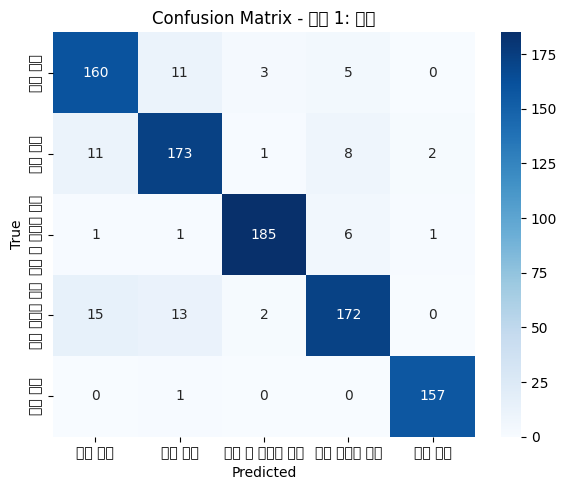

📋 Classification Report:
              precision    recall  f1-score   support

       협박 대화       0.86      0.89      0.87       179
       갈취 대화       0.87      0.89      0.88       195
 직장 내 괴롭힘 대화       0.97      0.95      0.96       194
   기타 괴롭힘 대화       0.90      0.85      0.88       202
       일반 대화       0.98      0.99      0.99       158

    accuracy                           0.91       928
   macro avg       0.92      0.92      0.92       928
weighted avg       0.91      0.91      0.91       928


📊 모델 2: 원본+Synonym


<ipython-input-58-6e8de357112f>:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54801 (\N{HANGUL SYLLABLE HYEOB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48149 (\N{HANGUL SYLLABLE BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44040 (\N{HANGUL SYLLABLE GAL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 52712 (\N{HANGUL SYLLABLE CWI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/u

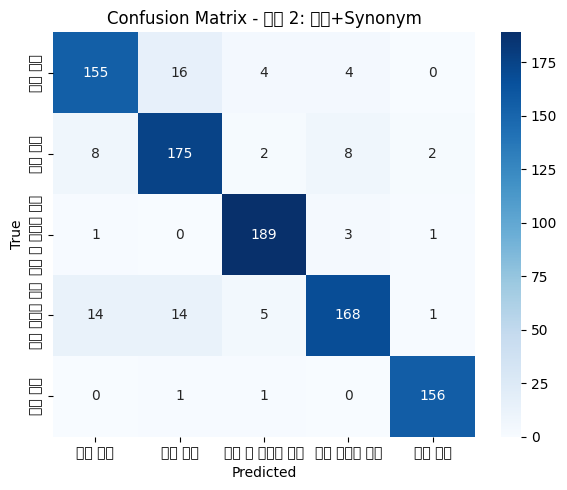

📋 Classification Report:
              precision    recall  f1-score   support

       협박 대화       0.87      0.87      0.87       179
       갈취 대화       0.85      0.90      0.87       195
 직장 내 괴롭힘 대화       0.94      0.97      0.96       194
   기타 괴롭힘 대화       0.92      0.83      0.87       202
       일반 대화       0.97      0.99      0.98       158

    accuracy                           0.91       928
   macro avg       0.91      0.91      0.91       928
weighted avg       0.91      0.91      0.91       928


📊 모델 3: 원본+EDA


<ipython-input-58-6e8de357112f>:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54801 (\N{HANGUL SYLLABLE HYEOB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48149 (\N{HANGUL SYLLABLE BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44040 (\N{HANGUL SYLLABLE GAL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 52712 (\N{HANGUL SYLLABLE CWI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/u

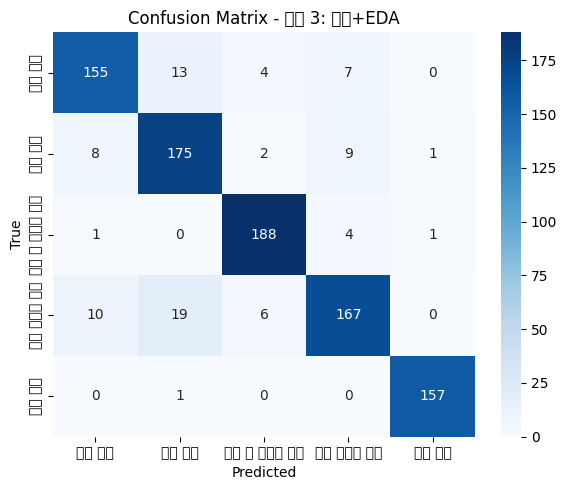

📋 Classification Report:
              precision    recall  f1-score   support

       협박 대화       0.89      0.87      0.88       179
       갈취 대화       0.84      0.90      0.87       195
 직장 내 괴롭힘 대화       0.94      0.97      0.95       194
   기타 괴롭힘 대화       0.89      0.83      0.86       202
       일반 대화       0.99      0.99      0.99       158

    accuracy                           0.91       928
   macro avg       0.91      0.91      0.91       928
weighted avg       0.91      0.91      0.91       928


📊 모델 4: 원본+Synonym+EDA


<ipython-input-58-6e8de357112f>:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54801 (\N{HANGUL SYLLABLE HYEOB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48149 (\N{HANGUL SYLLABLE BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44040 (\N{HANGUL SYLLABLE GAL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 52712 (\N{HANGUL SYLLABLE CWI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/u

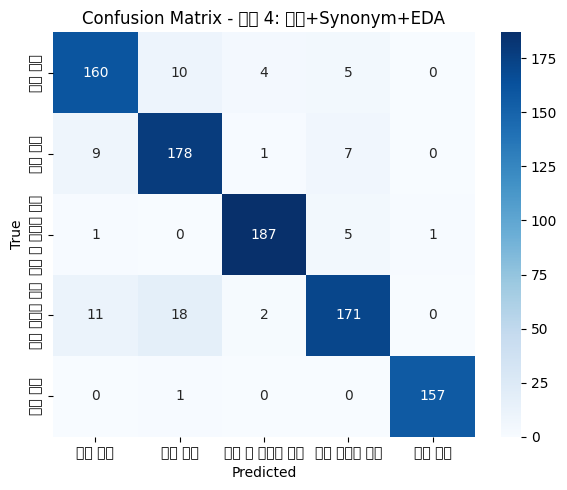

📋 Classification Report:
              precision    recall  f1-score   support

       협박 대화       0.88      0.89      0.89       179
       갈취 대화       0.86      0.91      0.89       195
 직장 내 괴롭힘 대화       0.96      0.96      0.96       194
   기타 괴롭힘 대화       0.91      0.85      0.88       202
       일반 대화       0.99      0.99      0.99       158

    accuracy                           0.92       928
   macro avg       0.92      0.92      0.92       928
weighted avg       0.92      0.92      0.92       928



In [58]:
# 🔹 클래스 이름 (라벨 순서대로)
ordered_columns = [
    "협박 대화",
    "갈취 대화",
    "직장 내 괴롭힘 대화",
    "기타 괴롭힘 대화",
    "일반 대화"
]

# 🔹 검증셋 준비
val_df = pd.DataFrame({"text": X_val_raw.tolist(), "label": y_val})
val_dataset = Dataset.from_pandas(val_df).map(tokenize_function, batched=True)
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

# 🔹 모델 이름 리스트 (시각화 제목용)
dataset_names = ["원본", "원본+Synonym", "원본+EDA", "원본+Synonym+EDA"]

# 🔹 반복 수행
print("\n🔍 모델별 Confusion Matrix 및 Classification Report")
for i, name in enumerate(dataset_names, 1):
    print(f"\n📊 모델 {i}: {name}")

    # 모델 불러오기
    model_path = f"./results/model_{i}"
    model = ElectraForSequenceClassification.from_pretrained(model_path).to(device)

    # 평가용 Trainer
    trainer = Trainer(model=model, tokenizer=tokenizer)

    # 예측 수행
    preds = trainer.predict(val_dataset)
    y_pred = np.argmax(preds.predictions, axis=1)
    y_true = y_val  # numpy array or list

    # 🔸 Confusion Matrix 계산
    cm = confusion_matrix(y_true, y_pred)

    # 🔸 시각화 + 저장
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=ordered_columns, yticklabels=ordered_columns)
    plt.title(f"Confusion Matrix - 모델 {i}: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()

    # 이미지로 저장
    img_path = f"confusion_matrix_model{i}_{name}.png"
    plt.savefig(img_path)
    plt.show()

    # 🔸 Classification Report 출력
    print("📋 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=ordered_columns))

In [ ]:
df_conversations_aihub = pd.read_csv(train_paths["conversations_aihub"])
aihub_general = aihub_df[aihub_df['class'] == '일반 대화'].copy()

# 2. 기존 데이터에서 '일반 대화' 제거
def filter_non_general(X, y):
    X_filtered = [x for x, label in zip(X, y) if label != custom_label_order['일반 대화']]
    y_filtered = [label for label in y if label != custom_label_order['일반 대화']]
    return X_filtered, y_filtered

X1_filtered, y1_filtered = filter_non_general(X1, y1)
X_syn_filtered, y_syn_filtered = filter_non_general(X_syn_only, y_syn_only)
X_eda_filtered, y_eda_filtered = filter_non_general(X_eda_only, y_eda_only)

X_general = aihub_general['conversation'].tolist()
y_general = aihub_general['class'].map(custom_label_order).values

# 4. 최종 X5, y5 구성
X5 = X1_filtered + X_syn_filtered + X_eda_filtered + X_general
y5 = np.concatenate([y1_filtered, y_syn_filtered, y_eda_filtered, y_general])

# 5. 확인
print(f"X5 샘플 수: {len(X5)}")
print(f"y5 클래스 분포: {np.unique(y5, return_counts=True)}")

# 텍스트와 라벨 추출
X_general = aihub_general['conversation'].tolist()
y_general = aihub_general['class'].map(custom_label_order).values

# 기존 증강까지 포함한 X4, y4에 일반대화 추가 → X5, y5 생성
X5 = X4 + X_general
y5 = np.concatenate([y4, y_general])

# 결과 확인
print(f"최종 샘플 수 X5: {len(X5)}, y5: {len(y5)}")
print(f"X5 샘플:\n{X5[:2]}")
print(f"y5 샘플:\n{y5[:2]}")

+ 데이터 EDA 때 예상한 대로 일반대화에 많이 과적합되었으며 직장 내 괴롭힘 대화는 점수가 높음
+ 나머지 세 카테고리에 대해서는 아쉬운 성능

## submission

In [ ]:
test_csv_path = os.path.join(csv_dir, 'test.csv')

df_test = pd.read_csv(test_csv_path)
conversations_test = df_test['text'].to_list()

X_text = preprocessing(conversations_test, tokenizer, INPUT_MAX_LENGTH)

In [ ]:
# 모델 예측 (Softmax를 사용하여 각 클래스에 대한 확률 계산)
predictions = model.predict(X_text)

# 예측 결과를 클래스 인덱스로 변환
predicted_classes = predictions.argmax(axis=1)

In [ ]:
# id와 예측된 클래스 저장
submission_df = pd.DataFrame({
    'idx': df_test['idx'],
    'class': predicted_classes
})

display(submission_df)

# submission.csv로 저장
submission_df.to_csv('/content/submission.csv', index=False)

## 제출 결과